In [1]:
import gym
import matplotlib.pyplot as plt


In [2]:
env = gym.make('MountainCar-v0')

In [3]:
# observation space and action space

obs_space = env.observation_space
action_space = env.action_space
print('The observation space: {}'.format(obs_space)) # velocity and position
# middle point between the two mountains is the origin
print('The action space: {}'.format(action_space))

The observation space: Box(-1.2000000476837158, 0.6000000238418579, (2,), float32)
The action space: Discrete(3)


In [4]:
# reset: resets the env to initial state and returns initial obs
# step: takes action and applies on env, env moves to a new state, returns next state, reward, done, info

In [5]:
obs = env.reset()
print(f'Initial observation: {obs}')

random_action = env.action_space.sample()

new_obs, reward, done, info = env.step(random_action)
print(f'New observation:{new_obs}')

Initial observation: [-0.4274808  0.       ]
New observation:[-0.42919174 -0.00171094]


In [6]:
env.render(mode="human")
env.close()

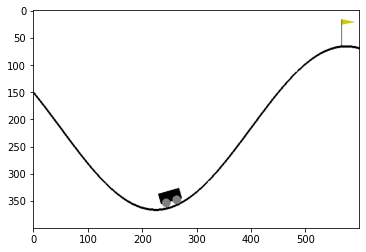

In [7]:
env_screen = env.render(mode='rgb_array')
env.close()
plt.imshow(env_screen)

In [8]:
import time

num_steps = 1500
obs = env.reset()

for step in range(num_steps):
    action = env.action_space.sample()

    obs, reward, done, info = env.step(action)

    env.render()

    time.sleep(0.001)

    if done:
        env.reset()

env.close()

# Spaces

Box and Discrete are types of data structures called "Spaces" provided by Gym

All of these data structures are derived from the gym.Space base class

## Box

In [9]:
type(env.observation_space)

gym.spaces.box.Box

Box corresponds to the n-dim continuous space; here n=2 ie a 2D space

The space is bounded by upper and lower limits which describe the legitimate values obs can take

Can determine this using high and low attributes of obs space; these correspond to the max and min positions/velocities our env can take

In [10]:
print(f'Upper bound for env obs: {env.observation_space.high}')
print(f'Lower bound for env obs: {env.observation_space.low}')

Upper bound for env obs: [0.6  0.07]
Lower bound for env obs: [-1.2  -0.07]


## Discrete

Describes a discrete space with [0,...,n-1] possible values; here n = 3

Meaning our action can take [0,1,2] only

Defines the allowed values strictly

Inputting a non-allowed action value will give an error

In [12]:
env.step(2)
print('Works')

# env.step(4)
# print('Doesn\'t works')

Works


# Wrappers